HeteroData(
  Value={ x=[8, 1, 768] },
  Field={ x=[4, 4] },
  Schema={ x=[1, 1] },
  Type={ x=[2, 2] },
  Instance={ x=[0, 0] },
  (Schema, inherits, Type)={ edge_index=[2, 2] },
  (Schema, has_field, Field)={ edge_index=[2, 4] },
  (Field, field_value, Value)={ edge_index=[2, 8] },
  (Type, rev_inherits, Schema)={ edge_index=[2, 2] },
  (Field, rev_has_field, Schema)={ edge_index=[2, 4] },
  (Value, rev_field_value, Field)={ edge_index=[2, 8] },
  (Instance, instance_of, Type)={ edge_index=[0] },
  (Type, rev_instance_of, Instance)={ edge_index=[0] }
)
Schema -> Field edges: tensor([[0, 0, 0, 0],
        [0, 1, 2, 3]])
Field -> Value edges: tensor([[3, 0, 1, 2, 3, 0, 1, 2],
        [0, 1, 2, 3, 4, 5, 6, 7]])
Schema -> Type (inherits) edges: tensor([[0, 0],
        [0, 1]])
Instance -> Type edges: tensor([])


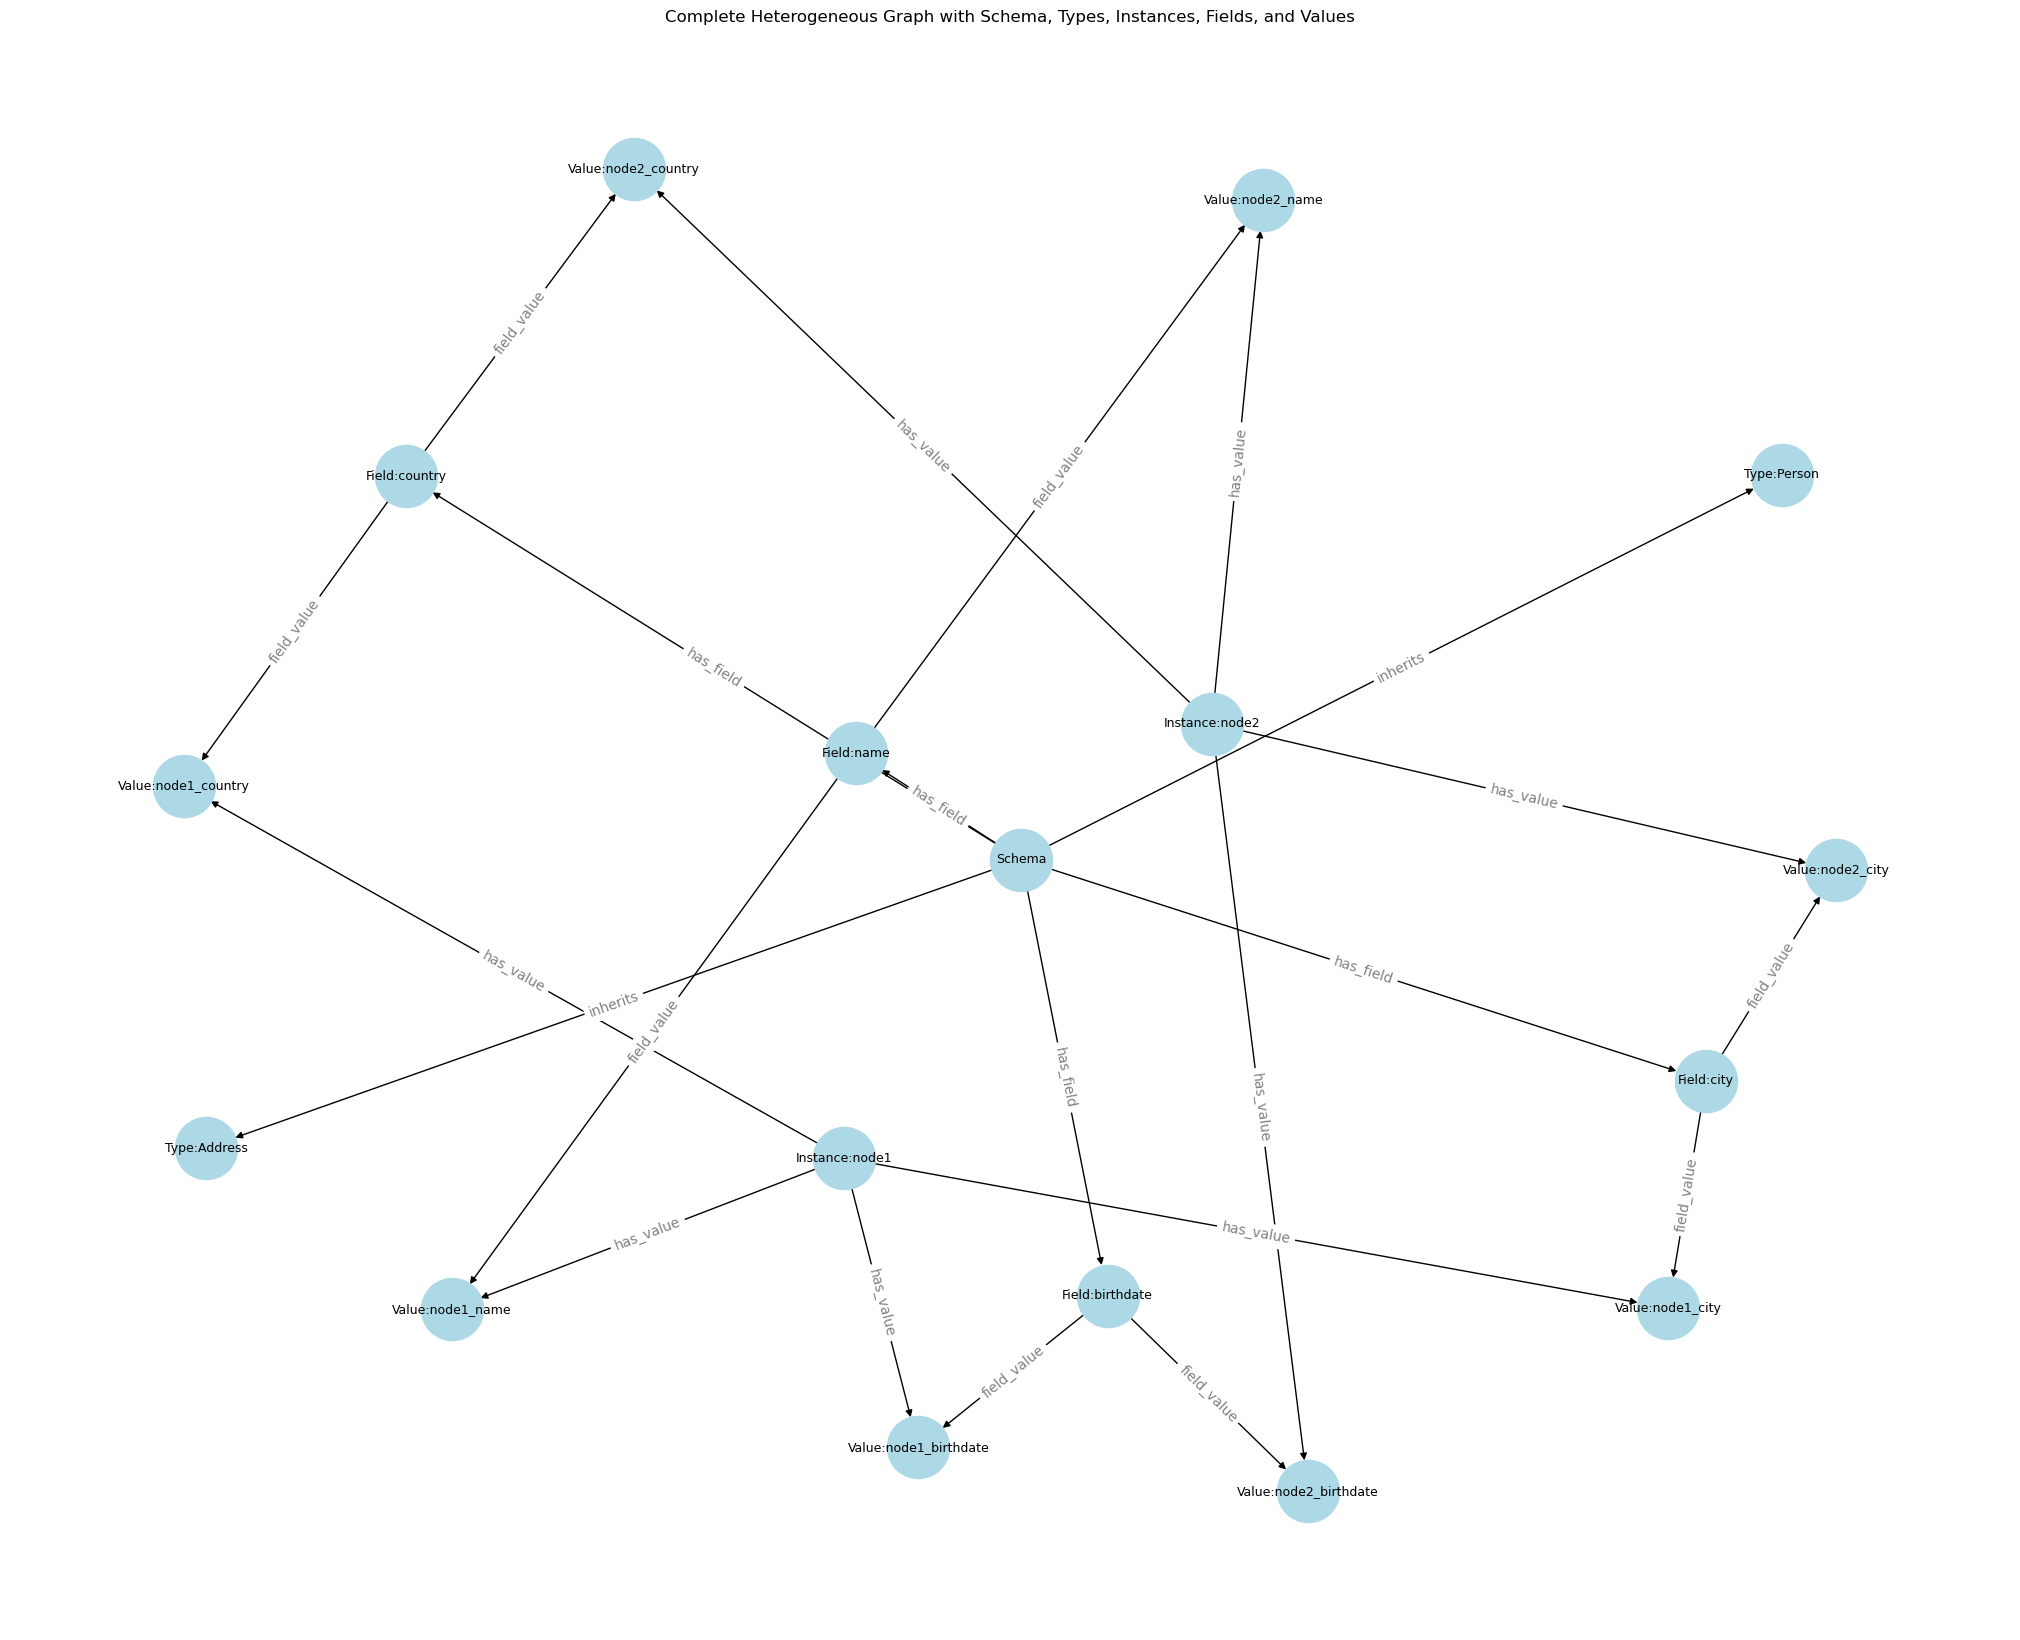

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [12]:
# Full Python Script: BERT Embeddings + PyG Heterogeneous Graph for R-GAT

import torch
from transformers import BertTokenizer, BertModel
from torch_geometric.data import HeteroData
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 1. Load BERT
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertModel.from_pretrained(bert_model_name)

# 2. Load instance data from CSV
# CSV format: node_id,field,value
instance_df = pd.read_csv("instance_data.csv")

# 3. Function to convert value to BERT embedding
@torch.no_grad()
def get_bert_embedding(text: str) -> torch.Tensor:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=16)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # CLS token

# 4. Build node feature dictionaries
value_nodes = {}
field_set = set()
instance_types = {}

for idx, row in instance_df.iterrows():
    node_id = row["node_id"]
    field = row["field"]
    value = str(row["value"])
    field_set.add(field)
    key = f"{node_id}_{field}"
    value_nodes[key] = get_bert_embedding(value)
    # Extract type from node_id if present (e.g., Person:001)
    if ":" in node_id:
        type_label, _ = node_id.split(":", 1)
        instance_types[node_id] = type_label

# 5. Define heterogeneous graph
data = HeteroData()

# Add Value nodes
data["Value"].x = torch.stack(list(value_nodes.values()))
value_node_index = {k: i for i, k in enumerate(value_nodes.keys())}

# Add Field nodes
field_list = sorted(list(field_set))
data["Field"].x = torch.eye(len(field_list))  # one-hot for fields
field_index = {f: i for i, f in enumerate(field_list)}

# Add Schema, Person, Address nodes
data["Schema"].x = torch.tensor([[1.0]])  # dummy feature
schema_entities = ["Person", "Address"]
data["Type"].x = torch.eye(len(schema_entities))
type_index = {t: i for i, t in enumerate(schema_entities)}

# 6. Create edges
# Schema inheritance
inheritance_edges = [(0, type_index[t]) for t in schema_entities]
data["Schema", "inherits", "Type"].edge_index = torch.tensor(inheritance_edges).t().contiguous()

# Schema has fields
schema_edges = [(0, field_index[f]) for f in field_list]
data["Schema", "has_field", "Field"].edge_index = torch.tensor(schema_edges).t().contiguous()

# Field to Value
field_value_edges = []
for key in value_nodes:
    node_id, field = key.split("_", 1)
    field_id = field_index[field]
    value_id = value_node_index[key]
    field_value_edges.append((field_id, value_id))

data["Field", "field_value", "Value"].edge_index = torch.tensor(field_value_edges).t().contiguous()

# Reverse relations
data["Type", "rev_inherits", "Schema"].edge_index = data["Schema", "inherits", "Type"].edge_index.flip(0)
data["Field", "rev_has_field", "Schema"].edge_index = data["Schema", "has_field", "Field"].edge_index.flip(0)
data["Value", "rev_field_value", "Field"].edge_index = data["Field", "field_value", "Value"].edge_index.flip(0)

# Instance to Type edges
data["Instance"].x = torch.eye(len(instance_types))
instance_index = {i: idx for idx, i in enumerate(instance_types.keys())}
instance_type_edges = [(instance_index[i], type_index[t]) for i, t in instance_types.items() if t in type_index]
data["Instance", "instance_of", "Type"].edge_index = torch.tensor(instance_type_edges).t().contiguous()
data["Type", "rev_instance_of", "Instance"].edge_index = data["Instance", "instance_of", "Type"].edge_index.flip(0)

# 7. Print graph structure
print(data)
print("Schema -> Field edges:", data["Schema", "has_field", "Field"].edge_index)
print("Field -> Value edges:", data["Field", "field_value", "Value"].edge_index)
print("Schema -> Type (inherits) edges:", data["Schema", "inherits", "Type"].edge_index)
print("Instance -> Type edges:", data["Instance", "instance_of", "Type"].edge_index)

# 8. Visualize the heterogeneous graph using NetworkX
G = nx.DiGraph()
G.add_node("Schema", type="Schema")

# Inheritance edges
for t in schema_entities:
    G.add_node(f"Type:{t}", type="Type")
    G.add_edge("Schema", f"Type:{t}", relation="inherits")

# Instance to Type edges and instance nodes
for instance_id, type_name in instance_types.items():
    G.add_node(f"Instance:{instance_id}", type="Instance")
    G.add_edge(f"Instance:{instance_id}", f"Type:{type_name}", relation="instance_of")

# Field edges
for field, idx in field_index.items():
    G.add_node(f"Field:{field}", type="Field")
    G.add_edge("Schema", f"Field:{field}", relation="has_field")

# Value edges and value nodes
for key in value_nodes:
    node_id, field = key.split("_", 1)
    field_node = f"Field:{field}"
    value_node = f"Value:{key}"
    instance_node = f"Instance:{node_id}"
    G.add_node(value_node, type="Value")
    G.add_edge(field_node, value_node, relation="field_value")
    G.add_edge(instance_node, value_node, relation="has_value")

plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, seed=42)
node_labels = {n: n for n in G.nodes()}
edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray')
plt.title("Complete Heterogeneous Graph with Schema, Types, Instances, Fields, and Values")
plt.axis('off')
plt.show()

# 9. GNN Training Setup
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data

# 9.1 Load real labels for Instance nodes from CSV (CSV must contain: node_id,label)
labels_df = pd.read_csv("instance_labels.csv")
label_map = {name: idx for idx, name in enumerate(sorted(labels_df['label'].unique()))}
data["Instance"].y = torch.tensor([
    label_map[labels_df[labels_df['node_id'] == i]['label'].values[0]]
    for i in instance_index.keys()
])
data["Instance"].train_mask = torch.ones(len(instance_index), dtype=torch.bool)

# 9.2 Define R-GAT model (Relational GAT)
from torch_geometric.nn import GATConv

class RGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x
from torch.nn import ModuleList, Linear

class RGCN(torch.nn.Module):
    def __init__(self, in_channels_dict, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels_dict["Instance"], hidden_channels, num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations=num_relations)

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict["Instance"], edge_index_dict)
        x = F.relu(x)
        x = self.conv2(x, edge_index_dict)
        return x

# 9.3 Create model and train (R-GAT)
model = RGAT(
    in_channels=data["Instance"].x.size(-1),
    hidden_channels=32,
    out_channels=len(label_map),
    heads=2
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Flatten edge index for Instance graph (assume indirect projection for demo)
from torch_geometric.utils import to_undirected
edge_index_dict = {}
relation_types = list(data.edge_types)

for i, rel in enumerate(relation_types):
    src, rel_type, dst = rel
    if src == "Instance" and dst == "Type":
        edge_index_dict[i] = data[rel].edge_index
    elif dst == "Instance" and src == "Type":
        edge_index_dict[i] = data[rel].edge_index

# Training loop
model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data["Instance"].x, data["Instance", "instance_of", "Type"].edge_index)
    loss = F.cross_entropy(out[data["Instance"].train_mask], data["Instance"].y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch:02d}, Loss: {loss.item():.4f}")